# Define morphological models with `neat.PhysTree`
The Class `neat.PhysTree` is used to define the physiological parameters of neuron models. It inherits from `neat.MorphTree` and thus has all its functionality. Just as `neat.MorphTree`, instances are initialized based on the standard `.swc` format:

In [1]:
from neat import PhysTree
ph_tree = PhysTree('morph/L23PyrBranco.swc')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Jul  2 2024 10:24:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Defining physiological parameters

A `PhysTree` consists of `neat.PhysNode` instances, which inherit from `neat.MorphNode`. Compared to a `MorphNode`, a `PhysNode` has extra attributes (initialized to some default value) defining physiological parameters:

In [2]:
# specific membrance capacitance (uF/cm^2)
print('default c_m node 1:', ph_tree[1].c_m)
# axial resisitance (MOhm*cm)
print('default r_a node 1:', ph_tree[1].r_a)
# point-like shunt located at {'node': node.index, 'x': 1.} (uS)
print('default g_shunt node 1:', ph_tree[1].g_shunt)
# leak and ion channel currents, stored in a dict with
# key: 'channel_name', value: [g_max, e_rev]
print('default currents node 1:', ph_tree[1].currents)

default c_m node 1: 1.0
default r_a node 1: 9.999999999999999e-05
default g_shunt node 1: 0.0
default currents node 1: {}


It is not recommended, and for ion channels even forbidden, to set the parameters directly via the nodes. Rather, the parameters should be specified with associated functions of `PhysTree`. These functions accept a `node_arg` keyword argument, which allows selecting a specific set of nodes. Parameters, can be given as `float`, in which case all nodes in `node_arg` will be set to the same value, a `dict` of `{node.index: parameter_value}`, or a callable function where the input is the distance of the middle of the node (`loc = {'node': node.index, 'x': .5}`) to the soma and the output the parameter.

Let's use `PhysTree.set_physiology()` to set capacitance (1st argument) and axial resistance (2nd argument) in the whole tree:

In [3]:
ph_tree.set_physiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)

Here, we defined the capacitance to be $.8$ $\mu$F/cm$^2$ when the mid-point of the node is less than 60 $\mu$m from the soma and $1.6*.8$ $\mu$F/cm$^2$, a common factor to take dendritic spines into account. Axial resistance was set to a constant value throughout the tree.

To set ion channels (see the 'Ionchannels in NEAT' tutorial on how to create your own ion channels), we must create the ion channel instance first. Here, we'll set a default sodium and potassium channel:

In [4]:
from neat.channels.channelcollection.channelcollection import Na_Ta, Kv3_1
# create the ion channel instances
na_chan = Na_Ta()
k_chan = Kv3_1()
# set the sodium channel only at the soma, with a reversal of 50 mV
ph_tree.add_channel_current(na_chan, 1.71*1e6, 50., node_arg=[ph_tree[1]])
# set the potassium channel throughout the dendritic tree, at 1/10th 
# of its somatic conductance, and with a reversal of -85 mV
gk_soma = 0.45*1e6
ph_tree.add_channel_current(k_chan, lambda x: gk_soma if x < .1 else gk_soma/10., -85.)

Now, we only have to set the leak current. We have two possibilities for this: (i) we could set the leak current by providing conductance and reversal in the standard way with `PhysTree.set_leak_current()` or (ii) with could fit the leak current to fix equilibrium potential and membrane time scale (if possible) with `PhysTree.fit_leak_current()`. We take the second option here:

In [5]:
# fit leak current to yield an equilibrium potential of -70 mV and
# a total membrane time-scale of 10 ms (with channel opening 
# probabilities evaluated at -70 mV)
ph_tree.fit_leak_current(-70., 10.)

## Inspecting the physiological parameters

We can now inspect the contents of various `PhysNode` instances:

In [6]:
# soma node
print(ph_tree[1])

PhysNode 1, Parent: None --- r_a = 0.0001 MOhm*cm, c_m = 0.8 uF/cm^2, v_ep = -70 mV, (g_Na_Ta = 1.71e+06 uS/cm^2, e_Na_Ta = 50 mV), (g_Kv3_1 = 450000 uS/cm^2, e_Kv3_1 = -85 mV), (g_L = 31.5408 uS/cm^2, e_L = -48.6388 mV)


In [7]:
# dendrite node
print(ph_tree[115])

PhysNode 115, Parent: 114 --- r_a = 0.0001 MOhm*cm, c_m = 1.28 uF/cm^2, v_ep = -70 mV, (g_Kv3_1 = 45000 uS/cm^2, e_Kv3_1 = -85 mV), (g_L = 123.193 uS/cm^2, e_L = -69.4148 mV)


Or, to get the full information on conductances and reversal potentials of membrane currents:

In [8]:
# soma node
print(ph_tree[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'L': [31.5408107318479, -48.638804987272735]}


In [9]:
# dendrite node
print(ph_tree[115].currents)

{'Kv3_1': [45000.0, -85.0], 'L': [123.19344287327353, -69.41475491536458]}


## Active dendrites compared to closest passive version

Imagine we aim to investigate the role of active dendritic channels, and to that purpose want to compare the active dendritic tree with a passive version. We may compute the leak conductance of this "passified" tree as the sum of all ion channel conductance evaluate at the equilibrium potential. The equilibrium potentials is stored on the tree using `PhysTree.set_v_ep()`:

In [10]:
ph_tree.set_v_ep(-70.)

To obtain the passified tree, we use `PhysTree.as_passive_membrane()`. However, this function will overwrite the parameters of the original nodes, if we want to maintain the initial tree, we have to copy it first:

In [11]:
# copy the initial tree
ph_tree_pas = PhysTree(ph_tree)
# set to passive (except the soma)
ph_tree_pas.as_passive_membrane([n for n in ph_tree_pas if n.index != 1])

We can now inspect the nodes:

In [12]:
# soma node
print(ph_tree_pas[1])

PhysNode 1, Parent: None --- r_a = 0.0001 MOhm*cm, c_m = 0.8 uF/cm^2, v_ep = -70 mV, (g_Na_Ta = 1.71e+06 uS/cm^2, e_Na_Ta = 50 mV), (g_Kv3_1 = 450000 uS/cm^2, e_Kv3_1 = -85 mV), (g_L = 31.5408 uS/cm^2, e_L = -48.6388 mV)


In [13]:
# dendrite node
print(ph_tree_pas[115])

PhysNode 115, Parent: 114 --- r_a = 0.0001 MOhm*cm, c_m = 1.28 uF/cm^2, v_ep = -70 mV, (g_Kv3_1 = 45000 uS/cm^2, e_Kv3_1 = -85 mV), (g_L = 123.193 uS/cm^2, e_L = -69.4148 mV)


And the currents:

In [14]:
# soma node
print(ph_tree_pas[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'L': [31.5408107318479, -48.638804987272735]}


In [15]:
# dendrite node
print(ph_tree_pas[115].currents)

{'Kv3_1': [45000.0, -85.0], 'L': [123.19344287327353, -69.41475491536458]}


Comparing this to the previously shown nodes of the full tree, we see that the dendrite nodes have been "passified".

## Computational tree

The computational tree in `PhysTree` works the same as in `MorphTree`, except that it's derivation also considers changes in physiological parameters, next to changes in morphological parameters.

In [16]:
ph_tree.set_comp_tree()
# compare number of nodes in computational tree and original tree
print('%d nodes in original tree'%(len(ph_tree)))
with ph_tree.as_computational_tree:
    print('%d nodes in computational tree'%(len(ph_tree)))

432 nodes in original tree
98 nodes in computational tree


Compare this to the number of nodes in the computational tree induced solely by the morphological parameters:

In [17]:
from neat import MorphTree
m_tree = MorphTree('morph/L23PyrBranco.swc')
m_tree.set_comp_tree()
with m_tree.as_computational_tree:
    print('%d nodes in computational `MorphTree`'%len(m_tree))

87 nodes in computational `MorphTree`


Note: only call this `PhysTree.set_comp_tree` when all physiological parameters have been set, and ***never*** change parameters stored at individual nodes when the computational tree is active, as this leads to the computational tree being inconsistent with the original tree.

# Copy construct

Before embarking on the computational capababilities of NEAT, we note that specific computations in NEAT are implemented by specific trees, i.e. equilibrium calculation by `neat.EquilibriumTree`, Green's function calculation in frequency resp. time domains by `neat.GreensTree` resp. `neat.GreensTreeTime`, separation of variables calculation by `neat.SOVTree`, creating simplifications by `neat.CompartmentFitter`, etc.

To do these computations, it is therefor necessary to create new trees from existing trees.
This can be done directly by the copy constructor, which makes a copy of the old tree into a new tree, by copying all attributes that the new tree's class and the old tree's class have in common.

In the next section, we'll use the following `GreensTree` created by copy construction:

In [18]:
from neat import GreensTree
greens_tree = GreensTree(ph_tree)

# Evaluate impedance matrices with `neat.GreensTree`

The class `neat.GreensTree` inherits from `neat.PhysTree` and implements Koch's algorithm [-@Koch1984] to calculate impedances in the Fourrier domain. For a given input current of frequency $\omega$ at location $x$, the impedance gives the linearized voltage response at a location $x^{\prime}$:
\begin{align}
v_{x^{\prime}}(\omega) = z_{x^{\prime}x}(\omega) \, i_x(\omega).
\end{align}
Applying the inverse Fourrier transform yields a convolution in the the time domain:
\begin{align}
v_{x^{\prime}}(t) = z_{x^{\prime}x}(t) \ast i_x(t),
\end{align}
with we call $z_{x^{\prime}x}(t) = FT^{-1} \left(  z_{x^{\prime}x}(\omega) \right)$ the impedance kernel. The steady state impedance is then:
\begin{align}
z_{x^{\prime}x} = \int_0^{\infty} \mathrm{d}t \, z_{x^{\prime}x}(t) = z_{x^{\prime}x}(\omega = 0).
\end{align}

## Computing an impedance kernel

For the calculation to proceed efficiently, `GreensTree` first sets effective, frequency-dependent boundary conditions for each cylindrical section. Hence we must specify the frequencies at which we want to evaluate impedances. If we aim to also compute temporal kernels, `neat.FourrierTools` is a handy tool to obtain the correct frequencies. Suppose for instance that we aim to compute an impedance kernels from $0$ to $50$ ms:

In [19]:
from neat import FourrierTools
import numpy as np
# create a Fourriertools instance with the temporal array on which to evaluate the impedance kernel
t_arr = np.linspace(0.,50.,1000)
ft = FourrierTools(t_arr)
# appropriate frequencies are stored in `ft.s`
# set the boundary condition for cylindrical segments in `greens_tree`
greens_tree.set_impedance(ft.s)

We can now compute for instance the impedance kernel between dendritic and somatic site:

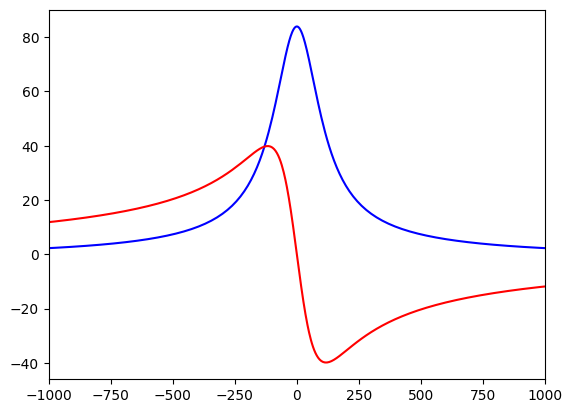

In [21]:
z_trans = greens_tree.calc_zf((1,.5), (115,.8))

# plot the kernel
import matplotlib.pyplot as pl
pl.plot(ft.s.imag, z_trans.real, 'b')
pl.plot(ft.s.imag, z_trans.imag, 'r')
pl.xlim((-1000.,1000.))
pl.show()

We can also obtain this kernel in the time domain with the `FourrierTools` object:

In [22]:
# time domain kernel
tt, zt = ft.ftInv(z_trans)

Note that using the `neat.GreensTree` is mostly useful if we need impedances in the frequency domain, we can easily compute kernels in the time domain using `neat.GreensTreeTime`. In fact, this tree class uses optimized inverse Fourier transform algorithms for different types of kernels (input or transfer), so it is recommended to not do the inverse Fourier transforms explicitly.

In [26]:
from neat import GreensTreeTime

greens_tree_time = GreensTreeTime(ph_tree)
greens_tree_time.set_impedance(t_arr)
zt_trans = greens_tree_time.calc_zt((1,.5), (115,.8)).real

ValueError: x and y must have same first dimension, but have shapes (1000,) and (2, 1000)

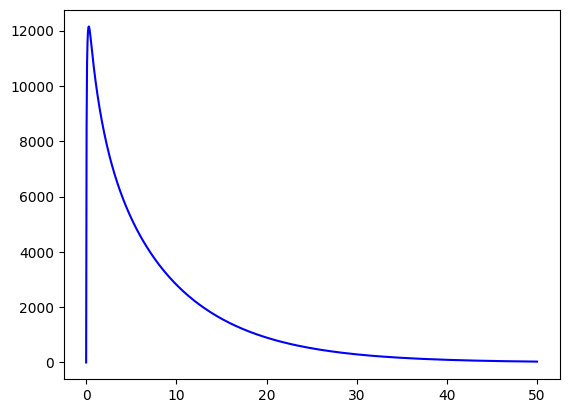

In [30]:
# comparison with NEURON simulation
from neat import NeuronSimTree, load_neuron_model
# load_neuron_model('TutorialChannels')
sim_tree = NeuronSimTree(ph_tree)
sim_tree.init_model(t_calibrate=300.)
i_amp, i_dur = 0.001, 0.1
sim_tree.add_i_clamp((115,.8), i_amp, 0., i_dur)
res = sim_tree.run(50.)
sim_tree.delete_model()
res['v_m'] -= res['v_m'][:,-1]
res['v_m'] /= (i_amp*1e-3*i_dur)

# plot the kernel
pl.plot(tt, zt.real, 'b', label='computed explicitly')
pl.plot(t_arr, zt_trans, 'c:', label='computed GreensTreeTime')
pl.plot(res['t'], res['v_m'][0], 'r--', label='simulated')
pl.legend(loc=0)
pl.show()

## Computing the impedance matrix

While `GreensTree.calc_zf()` could be used to explicitely compute the impedance matrix, `GreensTree.calc_impedance_matrix()` uses the symmetry and transitivity properties of impedance kernels to further optimize the calculation.

In [ ]:
z_locs = [(1,.5), (115,.8)]
z_mat = greens_tree.calc_impedance_matrix(z_locs)

This matrix has shape ``(len(ft.s), len(z_locs), len(z_locs))``. The zero-frequency component is at `ft.ind_0s`. Hence, the following gives the steady state impedance matrix:

In [ ]:
print(z_mat[ft.ind_0s])

[[ 88.07091747+0.j  83.93186356+0.j]
 [ 83.93186356+0.j 183.59769195+0.j]]
